In [6]:
import csv
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import random
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [7]:
def load_labels_as_dict():
    label_dict = {}
    with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        rows = list(reader)
        for row in tqdm(rows, desc="Loading labels"):
            label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]
        return label_dict

def search_in_ground_truth(file_id: str, label_dict: dict) -> str:
    wav_name = file_id + ".wav"
    return label_dict.get(wav_name, None)

def load_physical_features_as_df(csv_path: str, label_dict: dict) -> pd.DataFrame:
    df = pd.read_csv(csv_path, delimiter=",", encoding="utf-8")
    df_filtered = df[df['filename'].isin(label_dict.keys())]
    
    print(f"📊 Physical features loaded:")
    print(f"  Total rows in CSV: {len(df)}")
    print(f"  Filtered rows: {len(df_filtered)}")
    print(f"  Features: {list(df_filtered.columns)}")
    
    return df_filtered

def load_single_acoustic_embedding(npy_file):
    basename = os.path.splitext(os.path.basename(npy_file))[0]  
    embedding = np.load(npy_file)
    return basename, embedding

def load_acoustic_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading acoustic embeddings"))

    embedding_dict = dict(results)
    print(f"✅ Loaded {len(embedding_dict)} embeddings.")
    print(f"🧪 Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

def create_multimodal_features_with_concatenate(embeddings_dict, physical_features_df):    
    acoustic_data = []
    for file_id, embedding in embeddings_dict.items():
        filename = f"{file_id}.wav"
        
        acoustic_data.append({
            'filename': filename,
            'file_id': file_id,
            'embedding_idx': 0,
            'acoustic_features': embedding
        })
    
    acoustic_df = pd.DataFrame(acoustic_data)
    
    numeric_columns = physical_features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    columns_to_remove = ['split'] 
    for col in columns_to_remove:
        if col in numeric_columns:
            numeric_columns.remove(col)
            print(f"⚠️  Removed column: {col}")
    
    physical_subset = physical_features_df[['filename'] + numeric_columns].copy()
    
    merged_df = acoustic_df.merge(physical_subset, on='filename', how='left')
    
    merged_df[numeric_columns] = merged_df[numeric_columns].fillna(0)
    
    combined_features = {}
    
    for _, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Creating combined features"):
        file_id = row['file_id']
        embedding_idx = row['embedding_idx']
        
        acoustic = row['acoustic_features']
        physical = row[numeric_columns].values.astype(np.float32)
        combined = np.concatenate([acoustic, physical])
        
        if file_id not in combined_features:
            combined_features[file_id] = []
        combined_features[file_id].append(combined)
    
    for file_id in combined_features:
        if len(combined_features[file_id]) == 1:
            combined_features[file_id] = combined_features[file_id][0]
    
    print(f"📊 Multimodal features created:")
    print(f"  Files: {len(combined_features)}")
    print(f"  Acoustic features: {acoustic.shape[0]}")
    print(f"  Physical features: {len(numeric_columns)}")
    print(f"  Combined dimension: {combined.shape[0]}")
    print(f"  Used physical columns: {numeric_columns[:10]}...")  
    return combined_features

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        
    def forward(self, inputs):
        # inputs: (batch_size, embedding_dim)
        flat_input = inputs.view(-1, self.embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
        
        # Get closest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize
        quantized = torch.matmul(encodings, self.embedding.weight).view_as(inputs)
        
        # VQ loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        vq_loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        # Calculate perplexity
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()
        
        return quantized, vq_loss, encoding_indices.squeeze(), perplexity
    
class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 label_ratio = 2,
                 seed = 42  # Add seed parameter
                ):
        
        # Set seed for reproducibility
        random.seed(seed)
        
        self.data_map = {} 
        self.all_samples = []
        self.file_ids = list(embedding_dict.keys())
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
            ) 
            self.all_samples.append(sample)
        
        self.create_balanced_cold_dataset(label_ratio)
        
    def create_balanced_cold_dataset(self, label_ratio):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
                        
        num_healthy_samples = min(len(samples_by_label[1])*label_ratio, len(samples_by_label[0]))     
        self.balanced_samples = []
        
        for sample in samples_by_label[1]:
            self.balanced_samples.append(sample)
        
        # Use fixed seed for sampling
        healthy_samples = random.sample(samples_by_label[0], num_healthy_samples)
        self.balanced_samples.extend(healthy_samples)

        random.shuffle(self.balanced_samples)
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        sample = self.epoch_samples[idx]
        
        if len(sample) == 3:
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self, label_ratio):
        self.create_balanced_cold_dataset(label_ratio)
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
        }
        
        return stats
    
def focal_loss(logits, labels, alpha=0.25, gamma=2.0):
    ce_loss = F.cross_entropy(logits, labels, reduction='none')
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    return loss.mean()

In [9]:
class SupervisedVQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_embeddings, num_classes, commitment_cost=0.25):
        super(SupervisedVQVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        
        # Vector Quantizer
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        
        # Quantize
        quantized, vq_loss, encoding_indices, perplexity = self.vq(encoded)
        
        # Decode
        decoded = self.decoder(quantized)
        
        # Classify
        class_logits = self.classifier(quantized)
        
        return decoded, class_logits, vq_loss, encoding_indices, perplexity


In [10]:
def calculate_codebook_purity(model, data_loader, device='cuda'):
    model.eval()
    codebook_class_counts = {}
    
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device).squeeze()
            _, _, _, encoding_indices, _ = model(data)
            encoding_indices = encoding_indices.reshape(-1)
            labels = labels.reshape(-1)
            for idx, label in zip(encoding_indices.cpu().numpy(), labels.cpu().numpy()):
                if idx not in codebook_class_counts:
                    codebook_class_counts[idx] = {0: 0, 1: 0}
                codebook_class_counts[idx][label] += 1
    
    codebook_purities = {}
    total_samples = 0
    weighted_purity = 0.0
    for idx, class_counts in codebook_class_counts.items():
        total_for_idx = sum(class_counts.values())
        if total_for_idx > 0:
            purity = max(class_counts.values()) / total_for_idx
            codebook_purities[idx] = {
                'purity': purity,
                'total_samples': total_for_idx,
                'class_distribution': class_counts,
                'dominant_class': max(class_counts, key=class_counts.get)
            }
            weighted_purity += purity * total_for_idx
            total_samples += total_for_idx
    overall_purity = weighted_purity / total_samples if total_samples > 0 else 0.0
    return codebook_purities, overall_purity

def print_codebook_purity_analysis(codebook_purities, overall_purity):
    print(f"\n📊 Codebook Purity Analysis:")
    print(f"="*60)
    print(f"Overall Codebook Purity: {overall_purity:.4f}")
    print(f"Number of Used Codebook Entries: {len(codebook_purities)}")
    print(f"="*60)
    print(f"\n📋 Per-Entry Purity Details:")
    print(f"{'Index':<6} {'Purity':<8} {'Samples':<8} {'Dom.Class':<10} {'HC Count':<8} {'PC Count':<8}")
    print("-" * 60)
    for idx in sorted(codebook_purities.keys()):
        entry = codebook_purities[idx]
        purity = entry['purity']
        samples = entry['total_samples']
        dom_class = 'HC' if entry['dominant_class'] == 0 else 'PC'
        hc_count = entry['class_distribution'][0]
        pc_count = entry['class_distribution'][1]
        print(f"{idx:<6} {purity:<8.4f} {samples:<8} {dom_class:<10} {hc_count:<8} {pc_count:<8}")
    purities = [entry['purity'] for entry in codebook_purities.values()]
    if purities:
        print(f"\n📈 Purity Statistics:")
        print(f"  Average Purity: {np.mean(purities):.4f}")
        print(f"  Max Purity: {max(purities):.4f}")
        print(f"  Min Purity: {min(purities):.4f}")
        print(f"  Std Purity: {np.std(purities):.4f}")
    print(f"="*60)


In [11]:
def load_best_model(model_path, device='cuda'):
    """Load the best saved model"""
    # Fix for PyTorch 2.6 weights_only issue
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Get model configuration
    config = checkpoint['model_config']
    
    # Create model with saved configuration
    model = SupervisedVQVAE(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        embedding_dim=config['embedding_dim'],
        num_embeddings=config['num_embeddings'],
        num_classes=config['num_classes'],
        commitment_cost=config['commitment_cost']
    )
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    print(f"✅ Loaded model from: {model_path}")
    print(f"📊 Best validation UAR: {checkpoint['best_val_uar']:.4f}")
    print(f"🔢 Epoch: {checkpoint['epoch']}")
    
    return model, checkpoint

def calculate_uar(y_true, y_pred):
    """Calculate Unweighted Average Recall (UAR)"""
    from sklearn.metrics import recall_score
    
    # Calculate recall for each class
    recalls = recall_score(y_true, y_pred, average=None)
    
    # Return the mean of all class recalls (UAR)
    return np.mean(recalls)

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    all_perplexities = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).squeeze()
            
            _, class_logits, _, _, perplexity = model(data)
            _, predicted = torch.max(class_logits.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_perplexities.append(perplexity.item())
    
    # Calculate UAR as primary metric
    uar = calculate_uar(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['HC', 'PC'])
    avg_perplexity = np.mean(all_perplexities)
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    print(f"\n📊 Detailed Classification Results:")
    print(f"="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall UAR: {uar:.4f}")
    print(f"Average Perplexity: {avg_perplexity:.4f}")
    print(f"\n🎯 Per-Class Accuracy:")
    print(f"  HC (Healthy): {per_class_acc[0]:.4f}")
    print(f"  PC (Pathological): {per_class_acc[1]:.4f}")
    
    print(f"\n📋 Confusion Matrix:")
    print(f"     Predicted")
    print(f"       HC   PC")
    print(f"HC   {cm[0,0]:4d} {cm[0,1]:4d}")
    print(f"PC   {cm[1,0]:4d} {cm[1,1]:4d}")
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    
    # Sensitivity (True Positive Rate) for PC class
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Specificity (True Negative Rate) for HC class  
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Precision for PC class
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # F1 score for PC class
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    print(f"\n📈 Additional Metrics:")
    print(f"  Sensitivity (PC Recall): {sensitivity:.4f}")
    print(f"  Specificity (HC Recall): {specificity:.4f}")
    print(f"  Precision (PC): {precision:.4f}")
    print(f"  F1-Score (PC): {f1:.4f}")
    
    return uar, accuracy, report, cm, per_class_acc

In [12]:
def create_multimodal_features_with_addition(embeddings_dict, physical_features_df):    
    acoustic_data = []
    for file_id, embedding in embeddings_dict.items():
        filename = f"{file_id}.wav"
        
        acoustic_data.append({
            'filename': filename,
            'file_id': file_id,
            'embedding_idx': 0,
            'acoustic_features': embedding
        })
    
    acoustic_df = pd.DataFrame(acoustic_data)
    
    numeric_columns = physical_features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    columns_to_remove = ['split'] 
    for col in columns_to_remove:
        if col in numeric_columns:
            numeric_columns.remove(col)
            print(f"⚠️  Removed column: {col}")
    
    physical_subset = physical_features_df[['filename'] + numeric_columns].copy()
    
    merged_df = acoustic_df.merge(physical_subset, on='filename', how='left')
    
    merged_df[numeric_columns] = merged_df[numeric_columns].fillna(0)
    
    combined_features = {}
    
    for _, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Creating multimodal features with addition"):
        file_id = row['file_id']
        embedding_idx = row['embedding_idx']
        
        acoustic = row['acoustic_features']
        physical = row[numeric_columns].values.astype(np.float32)
        
        # Get dimensions
        acoustic_dim = acoustic.shape[0]
        physical_dim = len(physical)
        
        # Handle dimension mismatch
        if acoustic_dim > physical_dim:
            # Pad physical features to match acoustic dimension
            physical_padded = np.zeros(acoustic_dim, dtype=np.float32)
            physical_padded[:physical_dim] = physical
            combined = acoustic + physical_padded
        elif physical_dim > acoustic_dim:
            # Pad acoustic features to match physical dimension
            acoustic_padded = np.zeros(physical_dim, dtype=np.float32)
            acoustic_padded[:acoustic_dim] = acoustic
            combined = acoustic_padded + physical
        else:
            # Dimensions match, direct addition
            combined = acoustic + physical
        
        if file_id not in combined_features:
            combined_features[file_id] = []
        combined_features[file_id].append(combined)
    
    for file_id in combined_features:
        if len(combined_features[file_id]) == 1:
            combined_features[file_id] = combined_features[file_id][0]
    
    print(f"📊 Multimodal features created with addition:")
    print(f"  Files: {len(combined_features)}")
    print(f"  Acoustic features: {acoustic.shape[0]}")
    print(f"  Physical features: {len(numeric_columns)}")
    print(f"  Combined dimension: {combined.shape[0]}")
    print(f"  Fusion method: Element-wise addition")
    print(f"  Used physical columns: {numeric_columns[:10]}...")  
    return combined_features

In [13]:
# Load data
label_dict = load_labels_as_dict()
csv_path = "../model/audio_features.csv"
physical_features_df = load_physical_features_as_df(csv_path, label_dict)
    
# Load embeddings
embedding_dir = "../model/embeddings_lhl/"
val_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))
train_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "train_files"))
test_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "test_files"))
    
# Create multimodal features
combined_train_features = create_multimodal_features_with_addition(train_embeddings_dict, physical_features_df)
combined_val_features = create_multimodal_features_with_addition(val_embeddings_dict, physical_features_df)
combined_test_features = create_multimodal_features_with_addition(test_embeddings_dict, physical_features_df)
    
# Merge train and validation features for K-fold cross-validation
print(f"📊 Original Dataset Summary:")
print(f"Train features: {len(combined_train_features)} files")
print(f"Validation features: {len(combined_val_features)} files")
print(f"Test features: {len(combined_test_features)} files")
    
# Create a temporary dataset to get input dimension
val_dataset = ColdDetectionDataset(combined_val_features, label_dict, label_ratio=15)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
input_dim = next(iter(val_loader))[0].shape[1]
    
    # Model configuration
model_config = {
    'input_dim': input_dim,
    'hidden_dim': 1024,
    'embedding_dim': 256,
    'num_embeddings': 2,
    'num_classes': 2
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SupervisedVQVAE(
    input_dim=model_config['input_dim'],
    hidden_dim=model_config['hidden_dim'],
    embedding_dim=model_config['embedding_dim'],
    num_embeddings=model_config['num_embeddings'],
    num_classes=model_config['num_classes']
).to(device)


Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3805776.48it/s]


📊 Physical features loaded:
  Total rows in CSV: 28652
  Filtered rows: 19101
  Features: ['filename', 'split', 'duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'chroma_0_mean', 'chroma_0_std', 'chroma_1_mean', 'chroma_1_std', 'chroma_2_mean', 'chroma_2_std', 'chroma_3_mean', 'chroma_3_std', 'chroma_4_mean', 'chroma_4_std', 'chroma_5_mean', 'chroma_5_std', 'chroma_6_mean', 'chroma_6_std', 'chroma_7_mean', 'chroma_7_std', 'chroma_8_mean', 'chroma_8_std', 'chroma_9_mean', 'chroma_9_std', 'chroma_10_mean', 'chroma_10_std', 'chroma_11_mean', 'chroma_11_std', 'spectral_contrast_0_mean', 'spectral_contrast_0_std', 'spectral_contrast_1_mean', 'spectral_

Loading acoustic embeddings: 100%|██████████| 9596/9596 [00:01<00:00, 6197.01it/s]


✅ Loaded 9596 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 9505/9505 [00:01<00:00, 6016.83it/s]


✅ Loaded 9505 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 9551/9551 [00:01<00:00, 6169.95it/s]


✅ Loaded 9551 embeddings.
🧪 Sample shape: (3072,)


Creating multimodal features with addition: 100%|██████████| 9505/9505 [00:02<00:00, 4402.33it/s]


📊 Multimodal features created with addition:
  Files: 9505
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3072
  Fusion method: Element-wise addition
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...


Creating multimodal features with addition: 100%|██████████| 9596/9596 [00:02<00:00, 4433.21it/s]


📊 Multimodal features created with addition:
  Files: 9596
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3072
  Fusion method: Element-wise addition
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...


Creating multimodal features with addition: 100%|██████████| 9551/9551 [00:02<00:00, 4442.56it/s]


📊 Multimodal features created with addition:
  Files: 9551
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3072
  Fusion method: Element-wise addition
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...
📊 Original Dataset Summary:
Train features: 9505 files
Validation features: 9596 files
Test features: 9551 files


In [14]:
model, checkpoint = load_best_model("../model/saved_models/best_supervised_vqvae.pth", device=device)

✅ Loaded model from: ../model/saved_models/best_supervised_vqvae.pth
📊 Best validation UAR: 0.6503
🔢 Epoch: 46


In [33]:
codebook_purities, overall_purity = calculate_codebook_purity(model, val_dataset, device=device)
print_codebook_purity_analysis(codebook_purities, overall_purity)


📊 Codebook Purity Analysis:
Overall Codebook Purity: 0.8946
Number of Used Codebook Entries: 2

📋 Per-Entry Purity Details:
Index  Purity   Samples  Dom.Class  HC Count PC Count
------------------------------------------------------------
0      0.9313   7412     HC         6903     509     
1      0.7701   2184     HC         1682     502     

📈 Purity Statistics:
  Average Purity: 0.8507
  Max Purity: 0.9313
  Min Purity: 0.7701
  Std Purity: 0.0806


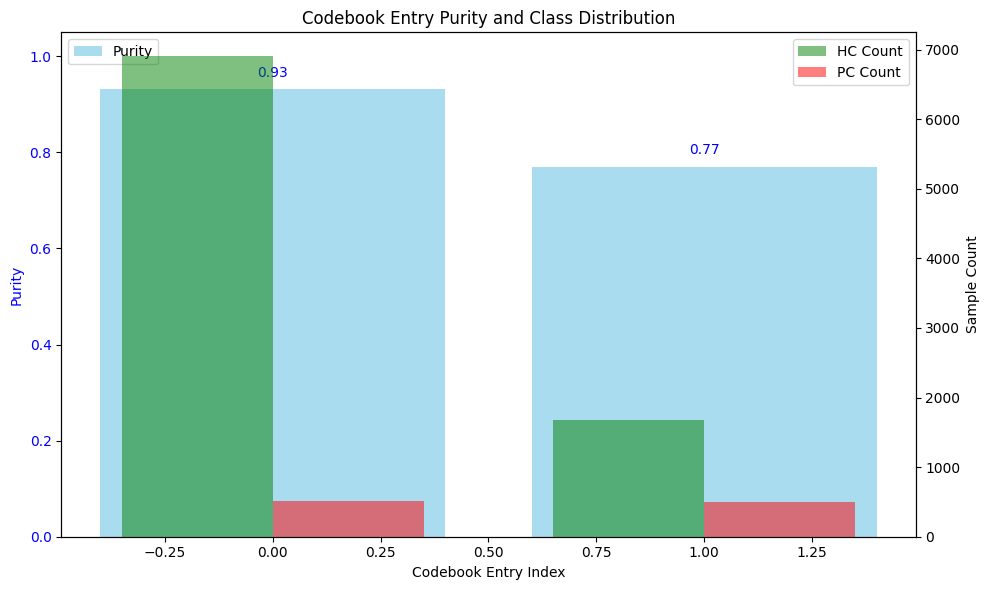

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_codebook_purity(codebook_purities):
    indices = list(codebook_purities.keys())
    purities = [codebook_purities[idx]['purity'] for idx in indices]
    hc_counts = [codebook_purities[idx]['class_distribution'][0] for idx in indices]
    pc_counts = [codebook_purities[idx]['class_distribution'][1] for idx in indices]
    total_counts = [codebook_purities[idx]['total_samples'] for idx in indices]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Purity bar
    ax1.bar(indices, purities, color='skyblue', alpha=0.7, label='Purity')
    ax1.set_xlabel('Codebook Entry Index')
    ax1.set_ylabel('Purity', color='blue')
    ax1.set_ylim(0, 1.05)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('Codebook Entry Purity and Class Distribution')

    # Add purity value on top
    for i, v in enumerate(purities):
        ax1.text(indices[i], v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10, color='blue')

    # Twin axis for class counts
    ax2 = ax1.twinx()
    width = 0.35
    ax2.bar(np.array(indices) - width/2, hc_counts, width=width, color='green', alpha=0.5, label='NC Count')
    ax2.bar(np.array(indices) + width/2, pc_counts, width=width, color='red', alpha=0.5, label='C Count')
    ax2.set_ylabel('Sample Count', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# 可视化codebook purity
plot_codebook_purity(codebook_purities)

In [35]:
def predict_test_set(model, test_loader, test_file_ids, device='cuda'):

    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for data, _ in test_loader: 
            data = data.to(device)
            
            _, class_logits, _, _, _ = model(data)
            probabilities = F.softmax(class_logits, dim=1)
            _, predicted = torch.max(class_logits.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    
    return all_preds, all_probs

def create_submission_file(test_file_ids, predictions, output_path='test_predictions.csv'):

    results = []
    
    for file_id, pred in zip(test_file_ids, predictions):
        # 0 -> 'NC' (No Cold), 1 -> 'C' (Cold)
        label = 'C' if pred == 1 else 'NC'
        results.append({
            'file_name': f"{file_id}.wav",
            'Cold': label
        })
    
    df = pd.DataFrame(results)
    df.to_csv(output_path, sep=';', index=False)
    
    print(f"✅ Submission file saved to: {output_path}")
    print(f"📊 Predictions summary:")
    print(f"  Total files: {len(results)}")
    print(f"  Cold (C): {sum(1 for r in results if r['Cold'] == 'C')}")
    print(f"  No Cold (NC): {sum(1 for r in results if r['Cold'] == 'NC')}")
    
    return df

class TestDataset(Dataset):
    def __init__(self, embedding_dict):
        self.samples = []
        self.file_ids = []
        
        for file_id, embedding in embedding_dict.items():
            self.samples.append(torch.tensor(embedding, dtype=torch.float32))
            self.file_ids.append(file_id)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx], self.file_ids[idx]

test_dataset = TestDataset(combined_test_features)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

test_file_ids = test_dataset.file_ids

print(f"📊 Test Dataset Info:")
print(f"  Total test files: {len(test_file_ids)}")
print(f"  Sample file IDs: {test_file_ids[:5]}")

predictions, probabilities = predict_test_set(model, test_loader, test_file_ids, device=device)

submission_df = create_submission_file(test_file_ids, predictions, 'test_predictions.csv')

print(f"\n📋 Sample predictions:")
print(submission_df.head(10))

print(f"\n📈 Sample prediction probabilities:")
for i in range(min(5, len(test_file_ids))):
    file_id = test_file_ids[i]
    pred = predictions[i]
    prob = probabilities[i]
    label = 'C' if pred == 1 else 'NC'
    print(f"  {file_id}.wav: {label} (NC: {prob[0]:.3f}, C: {prob[1]:.3f})")


📊 Test Dataset Info:
  Total test files: 9551
  Sample file IDs: ['test_0001', 'test_0002', 'test_0003', 'test_0004', 'test_0005']
✅ Submission file saved to: test_predictions.csv
📊 Predictions summary:
  Total files: 9551
  Cold (C): 3353
  No Cold (NC): 6198

📋 Sample predictions:
       file_name Cold
0  test_0001.wav    C
1  test_0002.wav    C
2  test_0003.wav    C
3  test_0004.wav    C
4  test_0005.wav   NC
5  test_0006.wav   NC
6  test_0007.wav    C
7  test_0008.wav   NC
8  test_0009.wav    C
9  test_0010.wav   NC

📈 Sample prediction probabilities:
  test_0001.wav: C (NC: 0.163, C: 0.837)
  test_0002.wav: C (NC: 0.163, C: 0.837)
  test_0003.wav: C (NC: 0.163, C: 0.837)
  test_0004.wav: C (NC: 0.163, C: 0.837)
  test_0005.wav: NC (NC: 0.911, C: 0.089)
✅ Submission file saved to: test_predictions.csv
📊 Predictions summary:
  Total files: 9551
  Cold (C): 3353
  No Cold (NC): 6198

📋 Sample predictions:
       file_name Cold
0  test_0001.wav    C
1  test_0002.wav    C
2  test_0003.

In [19]:
def predict_test_set(model, test_loader, test_file_ids, device='cuda'):

    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for data, _ in test_loader:  
            data = data.to(device)
            
            _, class_logits, _, _, _ = model(data)
            probabilities = F.softmax(class_logits, dim=1)
            _, predicted = torch.max(class_logits.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    
    return all_preds, all_probs

def create_submission_file(test_file_ids, predictions, output_path='test_predictions.tsv'):

    results = []
    
    for file_id, pred in zip(test_file_ids, predictions):
        # 0 -> 'NC' (No Cold), 1 -> 'C' (Cold)
        label = 'C' if pred == 1 else 'NC'
        results.append({
            'file_name': f"{file_id}.wav",
            'Cold': label
        })
    
    df = pd.DataFrame(results)
    df.to_csv(output_path, sep=';', index=False)
    
    print(f"✅ Submission file saved to: {output_path}")
    print(f"📊 Predictions summary:")
    print(f"  Total files: {len(results)}")
    print(f"  Cold (C): {sum(1 for r in results if r['Cold'] == 'C')}")
    print(f"  No Cold (NC): {sum(1 for r in results if r['Cold'] == 'NC')}")
    
    return df

class TestDataset(Dataset):
    def __init__(self, embedding_dict):
        self.samples = []
        self.file_ids = []
        
        for file_id, embedding in embedding_dict.items():
            self.samples.append(torch.tensor(embedding, dtype=torch.float32))
            self.file_ids.append(file_id)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx], self.file_ids[idx]

test_dataset = TestDataset(combined_test_features)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

test_file_ids = test_dataset.file_ids

print(f"📊 Test Dataset Info:")
print(f"  Total test files: {len(test_file_ids)}")
print(f"  Sample file IDs: {test_file_ids[:5]}")

predictions, probabilities = predict_test_set(model, test_loader, test_file_ids, device=device)

submission_df = create_submission_file(test_file_ids, predictions, 'test_predictions.csv')

print(f"\n📋 Sample predictions:")
print(submission_df.head(10))

print(f"\n📈 Sample prediction probabilities:")
for i in range(min(5, len(test_file_ids))):
    file_id = test_file_ids[i]
    pred = predictions[i]
    prob = probabilities[i]
    label = 'C' if pred == 1 else 'NC'
    print(f"  {file_id}.wav: {label} (NC: {prob[0]:.3f}, C: {prob[1]:.3f})")


📊 Test Dataset Info:
  Total test files: 9551
  Sample file IDs: ['test_0001', 'test_0002', 'test_0003', 'test_0004', 'test_0005']
✅ Submission file saved to: test_predictions.csv
📊 Predictions summary:
  Total files: 9551
  Cold (C): 3353
  No Cold (NC): 6198

📋 Sample predictions:
       file_name Cold
0  test_0001.wav    C
1  test_0002.wav    C
2  test_0003.wav    C
3  test_0004.wav    C
4  test_0005.wav   NC
5  test_0006.wav   NC
6  test_0007.wav    C
7  test_0008.wav   NC
8  test_0009.wav    C
9  test_0010.wav   NC

📈 Sample prediction probabilities:
  test_0001.wav: C (NC: 0.163, C: 0.837)
  test_0002.wav: C (NC: 0.163, C: 0.837)
  test_0003.wav: C (NC: 0.163, C: 0.837)
  test_0004.wav: C (NC: 0.163, C: 0.837)
  test_0005.wav: NC (NC: 0.911, C: 0.089)


In [16]:
print(val_dataset.get_statistics())

{'total_samples': 9596, 'epoch_samples': 9596}


In [21]:
val_file_ids = val_dataset.file_ids

predictions, probabilities = predict_test_set(model, val_loader, val_file_ids, device=device)

submission_df = create_submission_file(val_file_ids, predictions, 'val_predictions.csv')

AttributeError: 'ColdDetectionDataset' object has no attribute 'file_ids'